# Identify Object Positions in Images - YOLO vs VLM 

### Utils 
Taken from 
https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=wizbxA1lm-Tj
https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Object_detection.ipynb#scrollTo=245bc92a470f


In [ ]:
# @title Plotting Utils
import json
import random
import io
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, noun_phrases_and_positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, (noun_phrase, (y1, x1, y2, x2)) in enumerate(
        noun_phrases_and_positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# @title Parsing utils
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result

def parse_list_boxes_with_label(text):
  text = text.split("```\n")[0]
  return json.loads(text.strip("```").strip("python").strip("json").replace("'", '"').replace('\n', '').replace(',}', '}'))



Gemini Detection Results:
(1024, 1024)


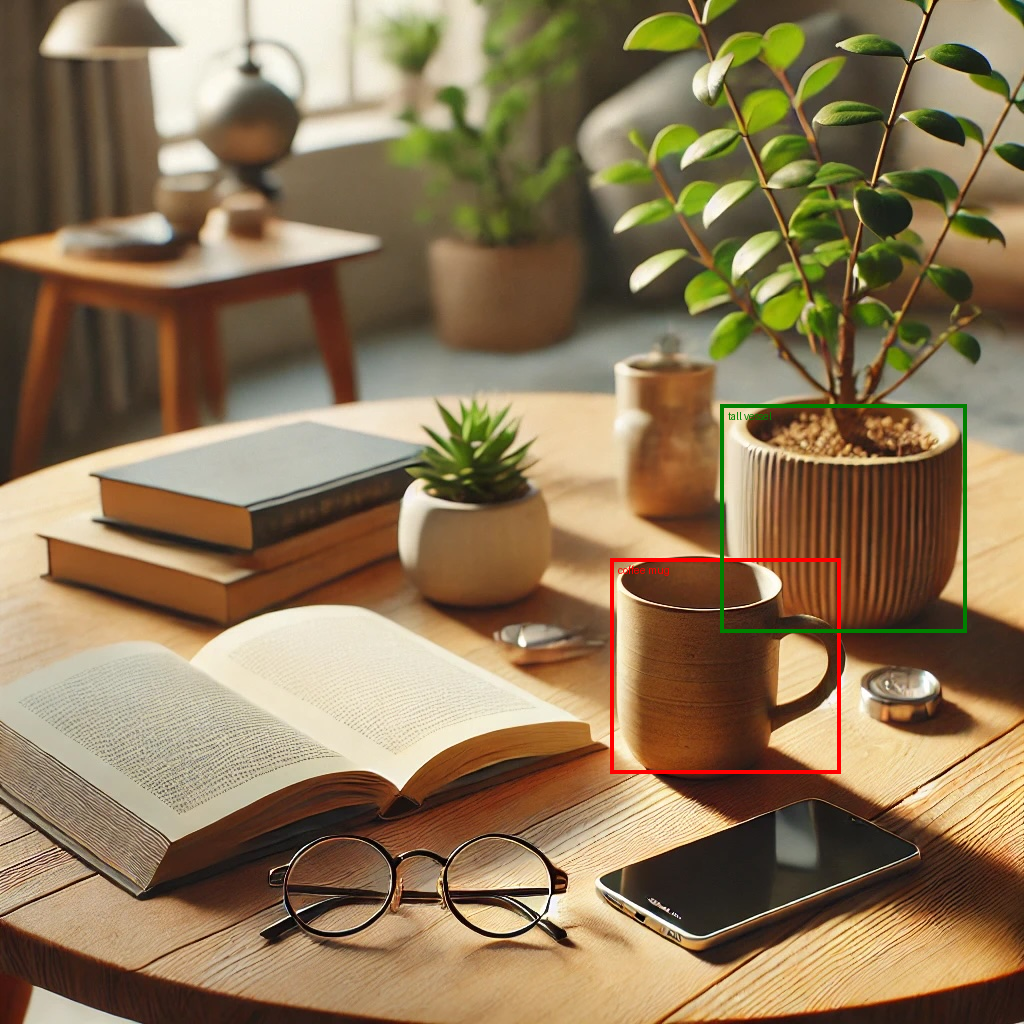


Raw Gemini output: ```json
[
  {"label": "coffee mug", "coordinates": [545, 596, 755, 821]},
  {"label": "tall vessel", "coordinates": [395, 704, 618, 944]}
]
```


In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import google.generativeai as genai
import os
import json

def detect_objects(image_path="/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg"):
    # Bild laden
    image = Image.open(image_path)
    
    # Gemini Setup
    genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
    model = genai.GenerativeModel("gemini-1.5-pro")

    # Präziser Prompt für Gemini
    prompt = """Analyze the image and find these specific items:
    1. The brown ceramic coffee mug with handle in the foreground
    2. The tall brown vessel/vase in the background
    
    Return their coordinates in this exact JSON format:
    [
        {"label": "coffee mug", "coordinates": [y1, x1, y2, x2]},
        {"label": "tall vessel", "coordinates": [y1, x1, y2, x2]}
    ]
    Be very precise with the coordinates to capture only the items, not surrounding space."""

    # Gemini Analyse durchführen
    response = model.generate_content([image, prompt])
    response.resolve()

    try:
        # Ergebnisse parsen
        gemini_results = parse_list_boxes_with_label(response.text)
        gemini_viz_data = [(item['label'], item['coordinates']) for item in gemini_results]
        
        # Visualisierung
        print("\nGemini Detection Results:")
        img_gemini = image.copy()
        plot_bounding_boxes(img_gemini, gemini_viz_data)
        
        # Rohergebnisse ausgeben
        print("\nRaw Gemini output:", response.text)
        
    except Exception as e:
        print("Error parsing Gemini results:", response.text)
        print("Error details:", str(e))

# Ausführung
detect_objects()


OWL-ViT Raw Detections:
[{'score': 0.6306137442588806, 'label': 'a brown ceramic coffee mug', 'box': {'xmin': 613, 'ymin': 550, 'xmax': 857, 'ymax': 784}}, {'score': 0.3979226052761078, 'label': 'a coffee cup with handle', 'box': {'xmin': 613, 'ymin': 550, 'xmax': 857, 'ymax': 784}}, {'score': 0.39525192975997925, 'label': 'a ceramic drinking vessel', 'box': {'xmin': 613, 'ymin': 550, 'xmax': 857, 'ymax': 784}}]

OWL-ViT found objects!
(1024, 1024)


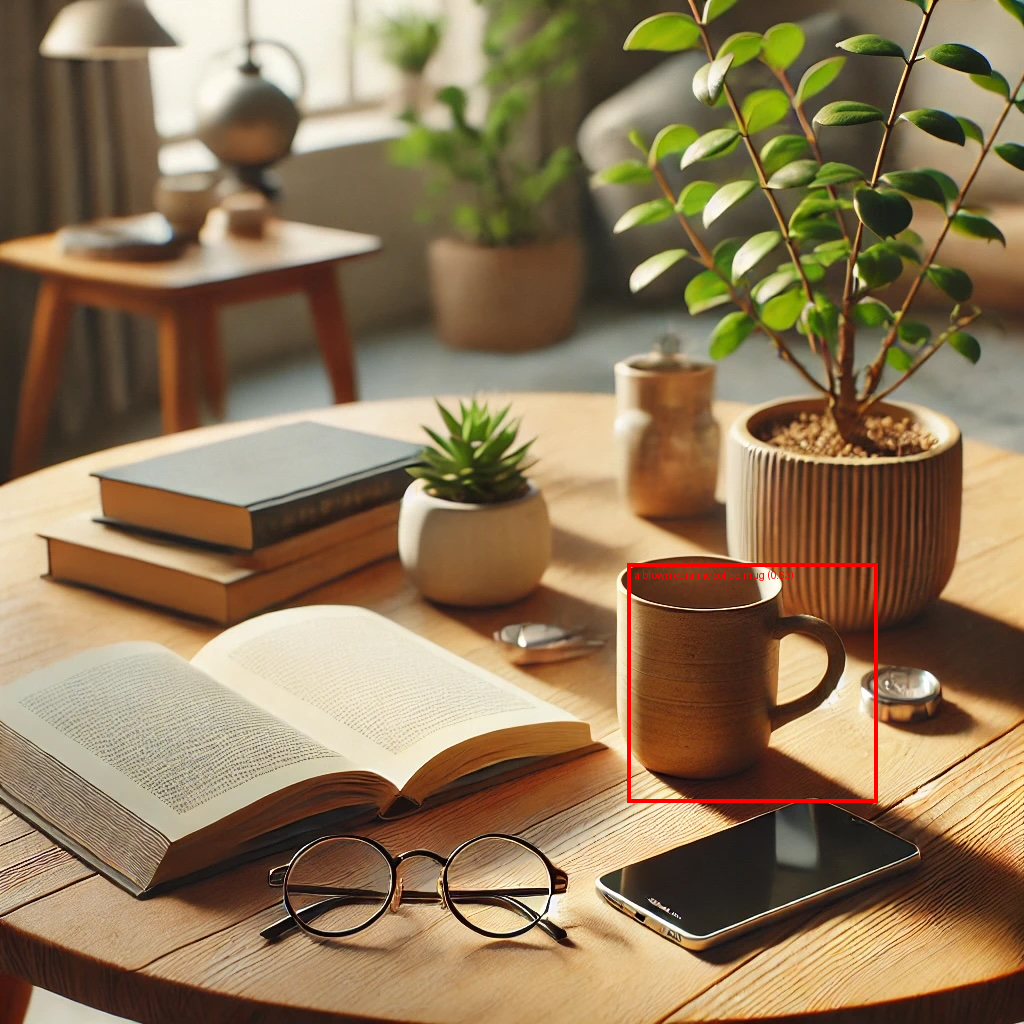

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline
import google.generativeai as genai
import os
import json

def detect_objects(image_path="/workspaces/MultimodalInteraction_ObjDet/images/table_scene.jpeg"):
    image = Image.open(image_path)
    
    detector = pipeline(
        model="google/owlvit-base-patch32",
        task="zero-shot-object-detection"
    )

    # Labels für die Erkennung
    text = [
        "a brown ceramic coffee mug",
        "a coffee cup with handle",
        "a ceramic drinking vessel"
    ]

    # Detektionen durchführen
    owl_output = detector(
        image,
        candidate_labels=text,
        threshold=0.3  # Nur höhere Konfidenzwerte
    )

    print("\nOWL-ViT Raw Detections:")
    print(owl_output)

    # Nur die besten Detektionen pro Region auswählen (um Duplikate zu vermeiden)
    seen_boxes = set()
    best_detections = []
    
    for detection in sorted(owl_output, key=lambda x: x['score'], reverse=True):
        box_key = f"{detection['box']['xmin']},{detection['box']['ymin']}"
        if box_key not in seen_boxes:
            seen_boxes.add(box_key)
            best_detections.append(detection)

    # Koordinaten für plot_bounding_boxes vorbereiten
    owl_results = []
    for detection in best_detections:
        box = detection['box']
        # Koordinaten im korrekten Format [y1, x1, y2, x2]
        coords = [
            box['ymin'],  # y1
            box['xmin'],  # x1
            box['ymax'],  # y2
            box['xmax']   # x2
        ]
        label = f"{detection['label']} ({detection['score']:.2f})"
        owl_results.append((label, coords))

    # Visualisierung
    if owl_results:
        print("\nOWL-ViT found objects!")
        img_owl = image.copy()
        plot_bounding_boxes(img_owl, owl_results)
    else:
        print("\nOWL-ViT found no objects!")

# Ausführung
detect_objects()